In [9]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

np.random.seed(20090425)

In [2]:
drug = (101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101)
placebo = (99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99)

y1 = np.array(drug)
y2 = np.array(placebo)

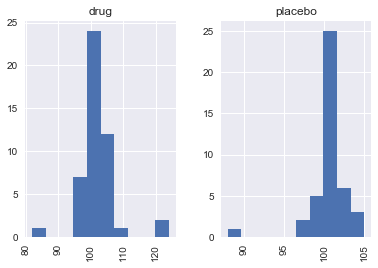

In [5]:
y = pd.DataFrame(dict(value = np.r_[y1, y2], 
                      group = np.r_[['drug']*len(drug), ['placebo']*len(placebo)]))

_ = y.hist('value', by = 'group')

In [10]:
mu_m = y.value.mean()
mu_s = y.value.std() * 2

with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', mu_m, sd = mu_s)
    group2_mean = pm.Normal('group2_mean', mu_m, sd = mu_s)

In [11]:
sigma_low = 1
sigma_hi = 10

with model:
    group1_std = pm.Uniform('group1_std', lower = sigma_low, upper = sigma_hi)
    group2_std = pm.Uniform('group2_std', lower = sigma_low, upper = sigma_hi)

In [12]:
with model:
    v = pm.Exponential('v_minus_one', 1/29.) + 1

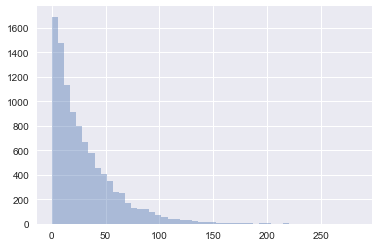

In [17]:
_ = sns.distplot(np.random.exponential(30, size = 10000), kde = False)

In [18]:
with model:
    lambda1 = group1_std ** -2
    lambda2 = group2_std ** -2
    
    group1 = pm.StudentT('drug', nu = v, mu = group1_mean, lam = lambda1,
                        observed = y1)
    group2 = pm.StudentT('placebo', nu = v, mu = group2_mean, lam = lambda2,
                        observed = y2)

In [20]:
with model:
    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
    effect_size = pm.Deterministic('effect size', diff_of_means/np.sqrt((group1_std**2 + group2_std**2) / 2))

In [21]:
with model:
    trace = pm.sample(2000, init = None, njobs = 2)

100%|██████████| 2000/2000 [01:01<00:00, 32.69it/s]


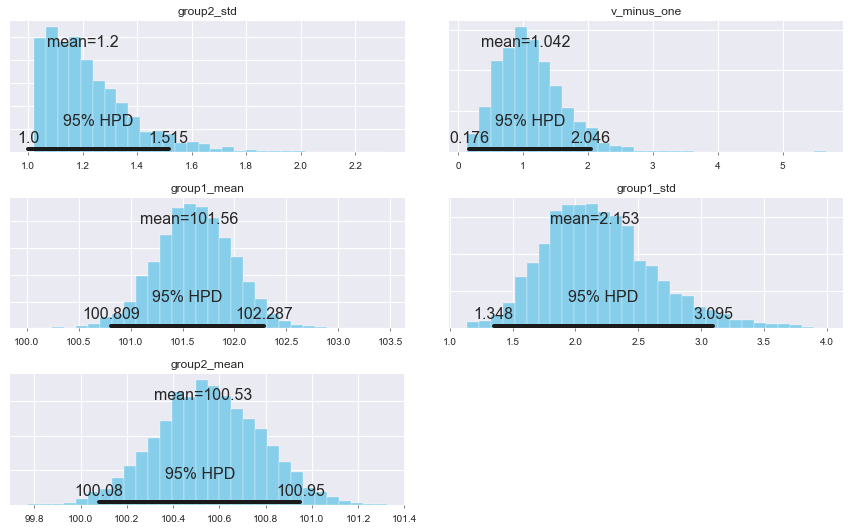

In [24]:
pm.plot_posterior(trace[100:],
                  varnames=['group1_mean', 'group2_mean', 'group1_std', 'group2_std', 'v_minus_one'],
                  color='#87ceeb');

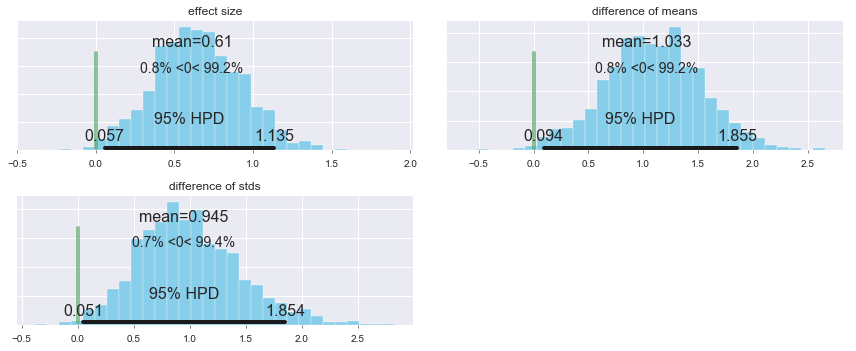

In [26]:
_ = pm.plot_posterior(trace[1000:],
                  varnames=['difference of means', 'difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb')

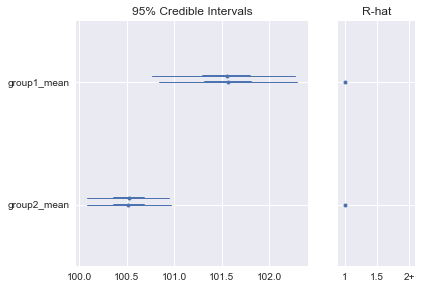

In [27]:
_ = pm.forestplot(trace[1000:], varnames=[v.name for v in model.vars[:2]])

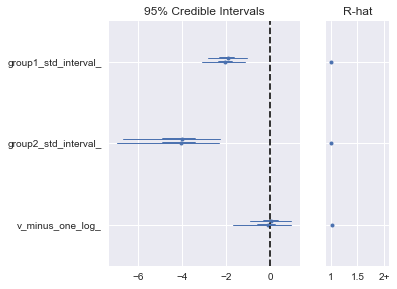

In [29]:
_ = pm.forestplot(trace[1000:], varnames=[v.name for v in model.vars[2:]])


In [30]:
pm.summary(trace[1000:],
                 varnames=['difference of means', 'difference of stds', 'effect size'])


difference of means:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.033            0.443            0.010            [0.094, 1.855]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.114          0.747          1.035          1.327          1.892


difference of stds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.945            0.460            0.018            [0.051, 1.854]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.137          0.623          0.905          1.222          1.990


effect size:

  Mean             SD               MC Error         95% HPD int